In [1]:
import pandas as pd

import matplotlib

import matplotlib.pyplot as plt

import scipy.stats

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.tsa.stattools as sts

from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt

from  scipy.stats.distributions import chi2

from statsmodels.tsa.stattools import grangercausalitytests

import numpy as np

import seaborn as sns

import itertools

import warnings

warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Dense,Dropout

from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf

import keras_tuner as kt

from keras_tuner import RandomSearch,HyperParameters

In [2]:
df = pd.read_csv('BD preprocesada II.csv',sep=',')

# Formatear columna Fecha como datetime

df['Fecha'] = pd.to_datetime(df['Fecha'])

# Fecha como índice

df.set_index('Fecha',inplace=True)

df.head()

,AUM FIC,Efectivo,Reserva Bancaria,Del sector privado,Del sector público,Cuentas de ahorro,CDT 1/,Otros depósitos a la vista,Inflación anual %,Tasa de intervención de política monetaria (%),...,Tasa A 120 días,Tasa Entre 121 y 179 días,Tasa A 180 días,Tasa Entre 181 y 359 días,Tasa A 360 días,Tasa Superiores a 360 días,Tasa Captaciones a través de CDT por red de oficinas,Tasa Captaciones a través de CDT por tesorería,Valor hoy,VALOR
Fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-01,4.277819e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.68,4.75,...,0.052668,0.055417,0.052354,0.058845,0.057049,0.061108,0.052959,0.058457,286.55,2940.94
2018-01-02,4.346588e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.052668,0.055417,0.052354,0.058845,0.057049,0.061108,0.052959,0.058457,286.55,2940.94
2018-01-03,4.427526e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.053122,0.056538,0.054354,0.059277,0.055647,0.065069,0.052840,0.064005,286.55,2940.94
2018-01-04,4.457223e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.050867,0.054752,0.053794,0.058336,0.056066,0.066029,0.052695,0.064102,286.55,2908.68
2018-01-05,4.464074e+07,58512.003886,28754.777759,35602.554628,10671.094981,170017.348229,160226.125352,5328.184972,3.37,4.75,...,0.051841,0.055389,0.054582,0.056345,0.055165,0.062512,0.052718,0.057780,286.55,2885.76


In [3]:
df.shape

(2433, 28)

In [4]:
diferencia = df.index.to_series().diff().dt.total_seconds()

diferencia.value_counts()

Fecha
86400.0    2410
0.0          22
Name: count, dtype: int64

In [5]:
df.drop_duplicates(keep='first',inplace=True,ignore_index=False)

In [6]:
df.shape

(2411, 28)

### Dividir en datos de entrenamiento, validación y prueba

In [7]:
def train_val_test_split(serie,tr_size=0.8,vl_size=0.1,ts_size=0.1):

     N = serie.shape[0]

     Ntrain = int(tr_size*N) # Número de datos de entrenamiento

     Nval = int(vl_size *N) # Número de datos de validación

     Ntest = N - Ntrain- Nval # Número de datos de prueba

     # Partición

     train = serie[0:Ntrain]
     val = serie[Ntrain:Ntrain+Nval]
     test = serie[Ntrain+Nval:]

     return train,val,test

In [8]:
tr,vl,ts = train_val_test_split(df['AUM FIC'])

print(f'Tamaño set de entrenamiento: {tr.shape}')

print(f'Tamaño set de validación: {vl.shape}')

print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (1928,)
Tamaño set de validación: (241,)
Tamaño set de prueba: (242,)


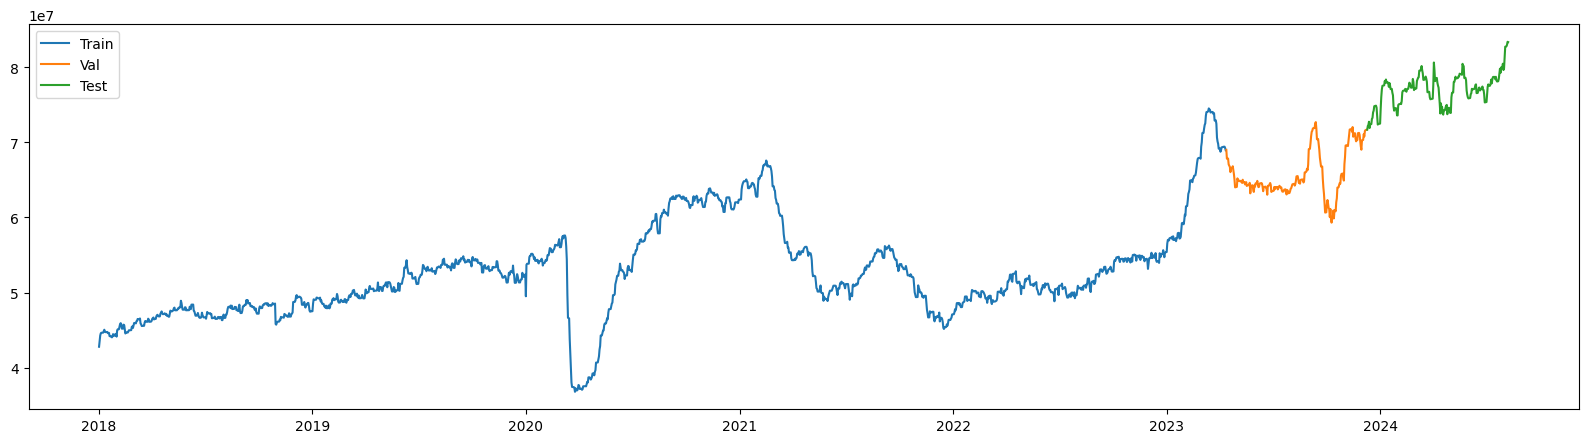

In [9]:
fig ,ax = plt.subplots(figsize = (20,5))

ax.plot(tr,label = 'Train')

ax.plot(vl,label = 'Val')

ax.plot(ts,label = 'Test')

plt.legend()

plt.show()

# Definir Funciones

In [10]:
def crear_dataset_supervisado (array,input_length,output_length):

    X, Y = [] , [] # Listados que contendran los datos de entrada y salida del modelo

    shape = array.shape

    if len(shape) ==1: # Si se tiene solo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils,cols=array.shape    

    # Generar los arreglos

    for  i in range(fils-input_length-output_length):

        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de Numpy

    X = np.array(X)

    Y = np.array(Y)

    return  X,Y

In [11]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [12]:
def escalar_dataset(data_input):

    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"

    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados

    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs

    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [13]:
def escalar_dataset2(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [14]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [15]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Modelo LSTM Univariado - Unistep

### Preprocesar datos para el modelo

#### Entrada

Batches = número de datos de entrenamiento

x input_length = tamaño del batch, en este caso de 30 días

x_features = el tamaño de las características que se toman, en este caso 1 porque solo hay una característica, el AUM

#### Salida

Batches = el mismo número de datos de entrenamiento

x output_length = tamaño del batch que quiero predecir en este caso un día

x output_features = el tamaño de las características que se toman, en este caso 1 porque solo hay una característica, el AUM

In [16]:
# Crear los datasets  de entrenamiento, prueba y validación para verificar sus tamaños

INPUT_LENGTH = 30

OUPUT_LENGHT= 1

x_tr, y_tr = crear_dataset_supervisado(tr.values,INPUT_LENGTH,OUPUT_LENGHT)

x_vl, y_vl = crear_dataset_supervisado(vl.values,INPUT_LENGTH,OUPUT_LENGHT)

x_ts, y_ts = crear_dataset_supervisado(ts.values,INPUT_LENGTH,OUPUT_LENGHT)

In [17]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (1897, 30, 1), y_tr: (1897, 1, 1)
Set de validación - x_vl: (210, 30, 1), y_vl: (210, 1, 1)
Set de prueba - x_ts: (211, 30, 1), y_ts: (211, 1, 1)


### Escalamiento de los datos

In [18]:
# Crear diccionario de entrada

data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [19]:
# Escalar

data_s, scaler = escalar_dataset(data_in)

In [20]:
# Extraer subsets escalados

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

### Crear y entrenar el modelo

In [21]:
tf.random.set_seed(123)

tf.config.experimental.enable_op_determinism()

N_UNITS = 256

INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUPUT_LENGHT, activation='linear'))

# Compilación

optimizador = RMSprop(learning_rate=0.0005)

modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Hiperparámetros

EPOCHS = 150
BATCH_SIZE = 256

# Entrenar el modelo

historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/150
8/8 - 2s - 270ms/step - loss: 0.1697 - val_loss: 0.1134
Epoch 2/150
8/8 - 1s - 71ms/step - loss: 0.0801 - val_loss: 0.0962
Epoch 3/150
8/8 - 1s - 68ms/step - loss: 0.0677 - val_loss: 0.0867
Epoch 4/150
8/8 - 1s - 67ms/step - loss: 0.0623 - val_loss: 0.0798
Epoch 5/150
8/8 - 1s - 66ms/step - loss: 0.0576 - val_loss: 0.0752
Epoch 6/150
8/8 - 1s - 66ms/step - loss: 0.0542 - val_loss: 0.0718
Epoch 7/150
8/8 - 1s - 65ms/step - loss: 0.0518 - val_loss: 0.0692
Epoch 8/150
8/8 - 1s - 73ms/step - loss: 0.0499 - val_loss: 0.0674
Epoch 9/150
8/8 - 1s - 79ms/step - loss: 0.0485 - val_loss: 0.0663
Epoch 10/150
8/8 - 1s - 72ms/step - loss: 0.0474 - val_loss: 0.0658
Epoch 11/150
8/8 - 1s - 85ms/step - loss: 0.0465 - val_loss: 0.0655
Epoch 12/150
8/8 - 1s - 71ms/step - loss: 0.0457 - val_loss: 0.0654
Epoch 13/150
8/8 - 1s - 72ms/step - loss: 0.0449 - val_loss: 0.0652
Epoch 14/150
8/8 - 1s - 71ms/step - loss: 0.0441 - val_loss: 0.0650
Epoch 15/150
8/8 - 1s - 76ms/step - loss: 0.0434 - val_l

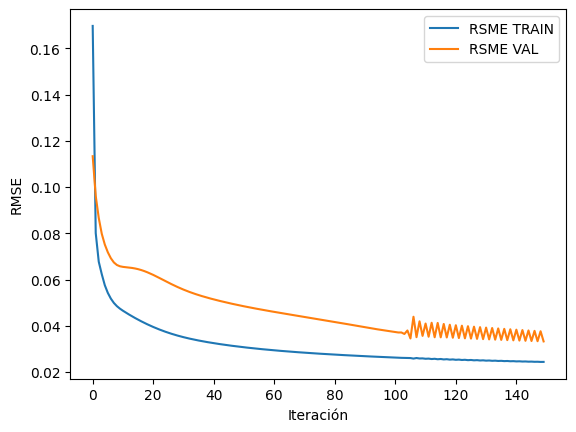

In [22]:
plt.plot(historia.history['loss'],label = 'RSME TRAIN')

plt.plot(historia.history['val_loss'],label = 'RSME VAL')

plt.xlabel('Iteración')

plt.ylabel('RMSE')

plt.legend()

plt.show()

### Desempeño del modelo

In [23]:
# Cálculo de RSME para train, val y test

rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.022
  RMSE val:	 0.032
  RMSE test:	 0.041


### Predicciones

In [24]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

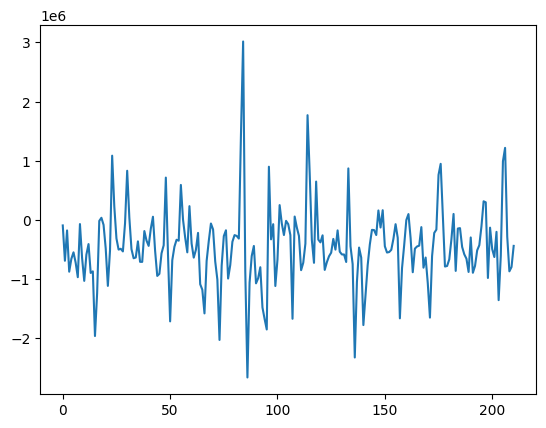

In [25]:
# Analizar el comportamiento de las predicciones a través de los errores

N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores)

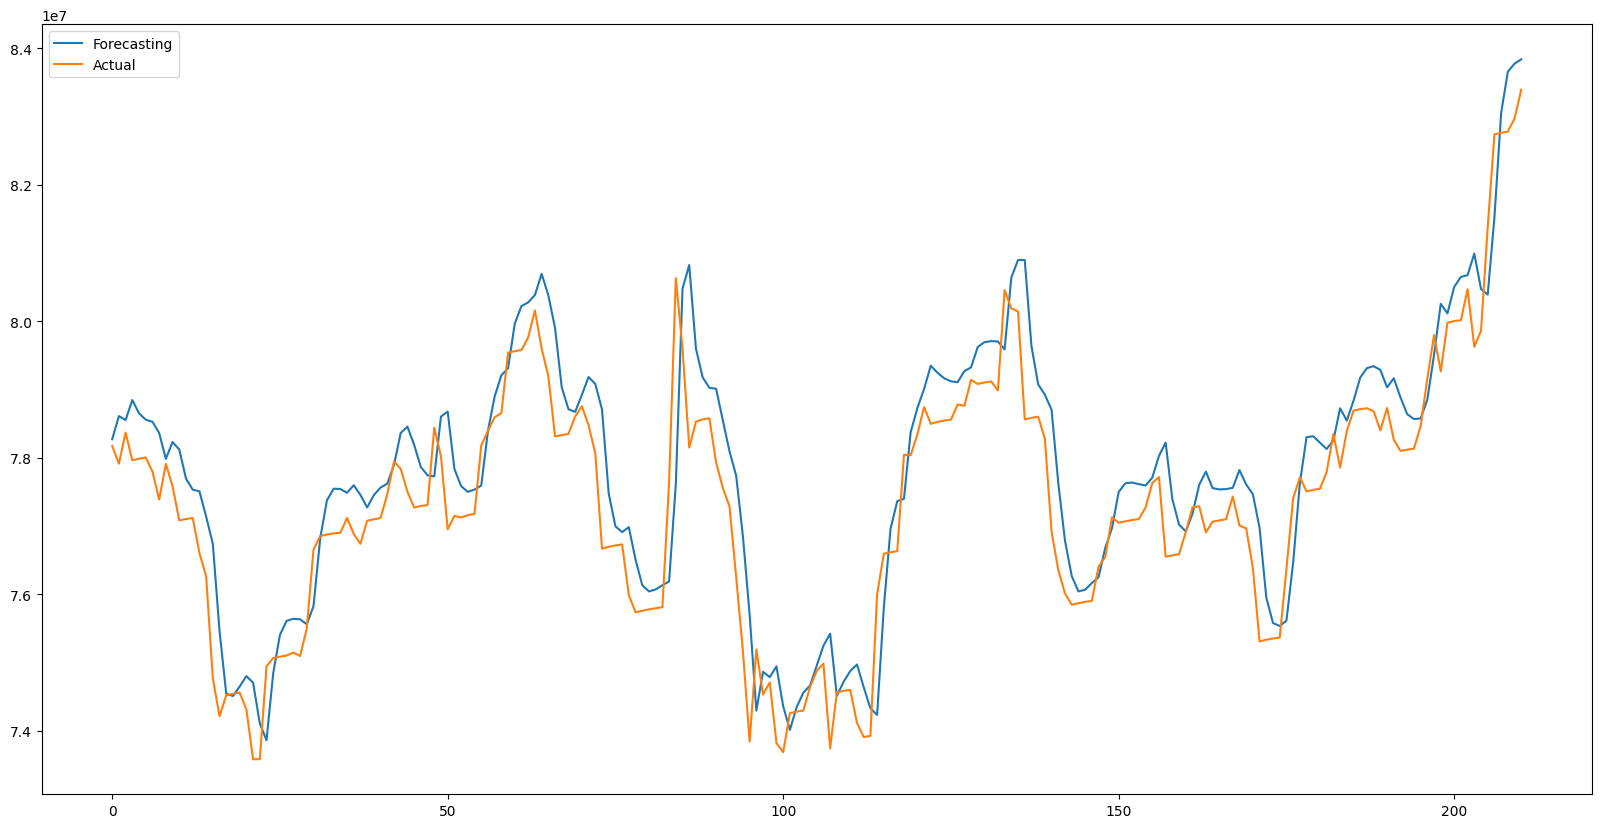

In [26]:
plt.subplots(figsize = (20,10))

plt.plot(y_ts_pred,label = 'Forecasting')

# plt.plot(ts,label = 'RSME TRAIN')

plt.plot(y_ts.flatten(),label = 'Actual')

plt.legend()

In [27]:
metricas_LSTM_1 = calculate_metrics(y_ts.flatten(),y_ts_pred)

## Afinar hiperparámetros

### Escribir la función crear modelo

In [28]:
# Semilla generador aleatorio
tf.random.set_seed(123)

INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

def build_model(hp):
    
    model = Sequential()

    # Capas LSTM

    model.add(LSTM(hp.Choice('units',values = [128,256,512]), return_sequences=True, input_shape=INPUT_SHAPE))

    
    # model.add(Dropout(hp.Choice('dropout',values = [0.1, 0.2, 0.3])))


    # Capas de salida

    model.add(Dense(OUPUT_LENGHT, activation='linear'))
    
    # Compilación del modelo

    optimizer = RMSprop(hp.Choice('learning_rate',values = [0.000005,0.00005, 0.0005, 0.005,0.05]))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')

      
    return model

In [29]:
tuner = RandomSearch(
    build_model,
    objective='val_loss', # Mérica de desempeño a usar en la afinación
    max_trials= 20,  # Número de combinaciones diferentes a probar
    # executions_per_trial=3,  # Número de veces que entrenarás cada modelo
    directory='my_dir',
    project_name='LSTM_tuning',
    overwrite = True
)

In [30]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
learning_rate (Choice)
{'default': 5e-06, 'conditions': [], 'values': [5e-06, 5e-05, 0.0005, 0.005, 0.05], 'ordered': True}


In [31]:
tuner.search(x_tr_s, y_tr_s, 
             epochs=150,
             batch_size=256,
             validation_data=(x_vl_s, y_vl_s))

Trial 15 Complete [00h 03m 27s]
val_loss: 0.08369123190641403

Best val_loss So Far: 0.02572161890566349
Total elapsed time: 00h 36m 20s


In [32]:
# Imprimir resumen de la afinación

tuner.results_summary()

Results summary
Results in my_dir\LSTM_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
units: 128
learning_rate: 0.05
Score: 0.02572161890566349

Trial 01 summary
Hyperparameters:
units: 256
learning_rate: 0.05
Score: 0.031011056154966354

Trial 05 summary
Hyperparameters:
units: 128
learning_rate: 0.005
Score: 0.03367674723267555

Trial 12 summary
Hyperparameters:
units: 512
learning_rate: 0.005
Score: 0.033795639872550964

Trial 13 summary
Hyperparameters:
units: 256
learning_rate: 0.005
Score: 0.033803440630435944

Trial 00 summary
Hyperparameters:
units: 512
learning_rate: 0.05
Score: 0.03627603501081467

Trial 02 summary
Hyperparameters:
units: 512
learning_rate: 0.0005
Score: 0.036786217242479324

Trial 10 summary
Hyperparameters:
units: 128
learning_rate: 0.0005
Score: 0.03683857619762421

Trial 09 summary
Hyperparameters:
units: 256
learning_rate: 0.0005
Score: 0.03697279095649719

Trial 06 summary
Hyperparameters:
un

In [33]:
# # Extraer el mejor modelo
mejor_modelo = tuner.get_best_models(num_models=1)[0]
mejor_modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30, 1)          │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
predecir = mejor_modelo.predict(x_ts_s,verbose=0)[:,0,:]

predecir = scaler.inverse_transform(predecir)

In [35]:
# Cálculo de RSME para train, val y test

rmse_tr = mejor_modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = mejor_modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = mejor_modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.019
  RMSE val:	 0.026
  RMSE test:	 0.402


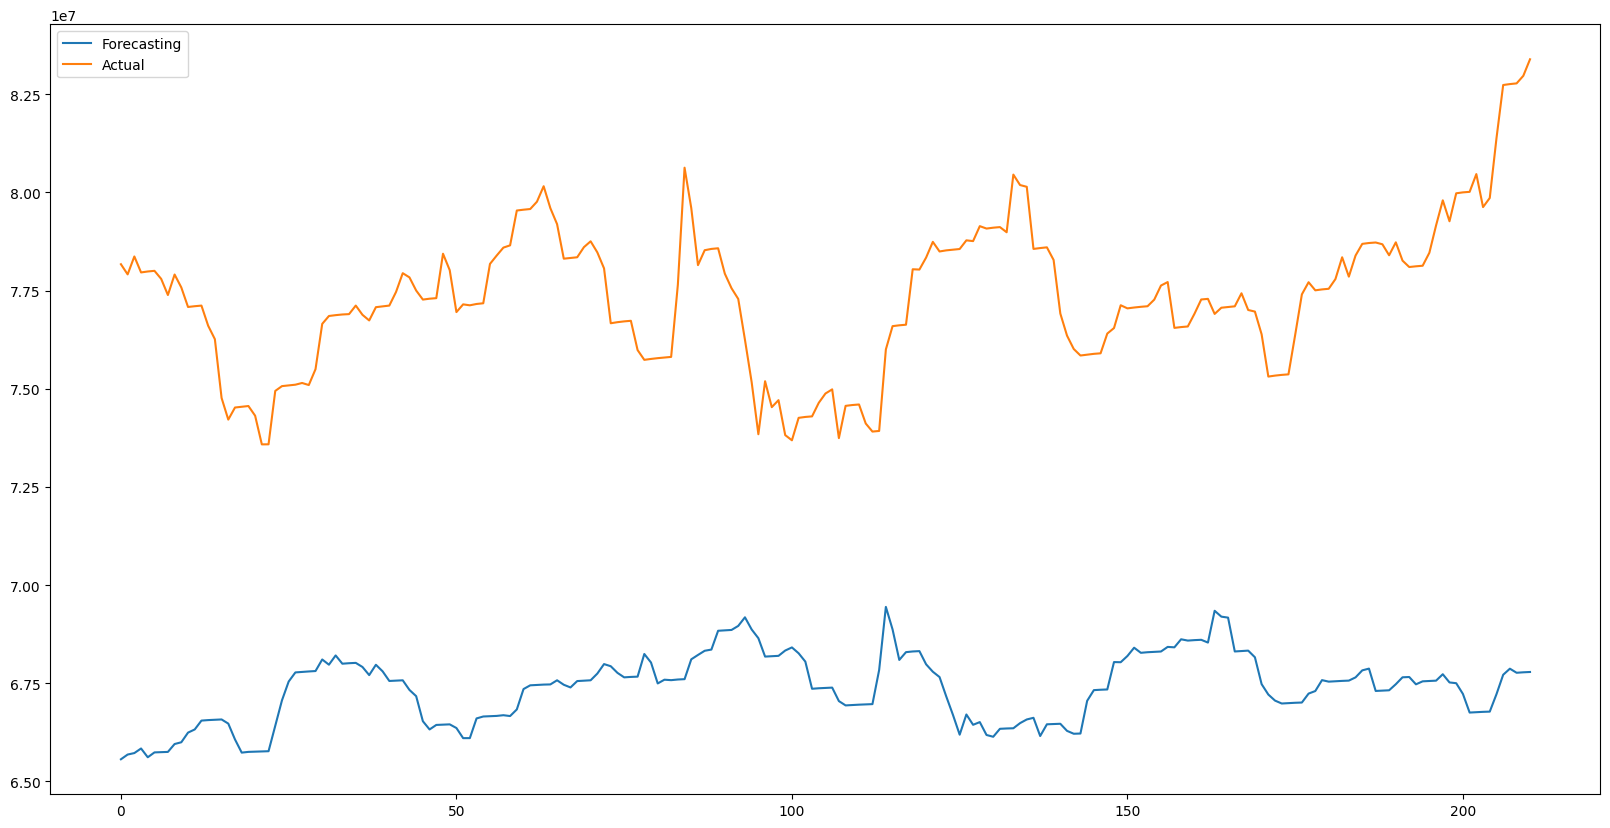

In [36]:
plt.subplots(figsize = (20,10))

plt.plot(predecir,label = 'Forecasting')

# plt.plot(ts,label = 'RSME TRAIN')

plt.plot(y_ts.flatten(),label = 'Actual')

plt.legend()

In [37]:
metricas_LSTM_2 = calculate_metrics(y_ts.flatten(),predecir)

# Modelo Univariado - Multistep

## Preprocesamiento 

#### Entrada

Batches = número de datos de entrenamiento

x input_length = tamaño del batch, en este caso de 60 días

x_features = el tamaño de las características que se toman, en este caso 1 porque solo hay una característica, el AUM

#### Salida

Batches = número de predicciones

x output_length = tamaño del batch que quiero predecir en este caso 7 días

x output_features = el tamaño de las características que se toman, en este caso 1 porque solo hay una característica, el AUM

In [38]:
INPUT_LENGTH_2 = 30

OUPUT_LENGHT_2 = 3

x_tr, y_tr = crear_dataset_supervisado(tr.values,INPUT_LENGTH_2,OUPUT_LENGHT_2)

x_vl, y_vl = crear_dataset_supervisado(vl.values,INPUT_LENGTH_2,OUPUT_LENGHT_2)

x_ts, y_ts = crear_dataset_supervisado(ts.values,INPUT_LENGTH_2,OUPUT_LENGHT_2)


print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (1895, 30, 1), y_tr: (1895, 3, 1)
Set de validación - x_vl: (208, 30, 1), y_vl: (208, 3, 1)
Set de prueba - x_ts: (209, 30, 1), y_ts: (209, 3, 1)


## Escalamiento

In [39]:
# Crear diccionario de entrada

data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [40]:
# Escalar

data_s, scaler = escalar_dataset(data_in)

In [41]:
# Extraer subsets escalados

x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

## Entrenamiento del modelo

In [42]:
tf.random.set_seed(123)

tf.config.experimental.enable_op_determinism()

N_UNITS = 256

INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

modelo_2 = Sequential()
modelo_2.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo_2.add(Dense(OUPUT_LENGHT_2, activation='linear'))

# Compilación

optimizador = RMSprop(learning_rate=0.001)

modelo_2.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Hiperparámetros

EPOCHS = 50

BATCH_SIZE = 256

# Entrenar el modelo

historia = modelo_2.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/50
8/8 - 1s - 174ms/step - loss: 0.2061 - val_loss: 0.2602
Epoch 2/50
8/8 - 1s - 84ms/step - loss: 0.1178 - val_loss: 0.1214
Epoch 3/50
8/8 - 1s - 98ms/step - loss: 0.0942 - val_loss: 0.1054
Epoch 4/50
8/8 - 1s - 91ms/step - loss: 0.0851 - val_loss: 0.1064
Epoch 5/50
8/8 - 1s - 94ms/step - loss: 0.0694 - val_loss: 0.1076
Epoch 6/50
8/8 - 1s - 95ms/step - loss: 0.0667 - val_loss: 0.0871
Epoch 7/50
8/8 - 1s - 82ms/step - loss: 0.0653 - val_loss: 0.0749
Epoch 8/50
8/8 - 1s - 88ms/step - loss: 0.0652 - val_loss: 0.0759
Epoch 9/50
8/8 - 1s - 83ms/step - loss: 0.0596 - val_loss: 0.0766
Epoch 10/50
8/8 - 1s - 89ms/step - loss: 0.0616 - val_loss: 0.0747
Epoch 11/50
8/8 - 1s - 81ms/step - loss: 0.0623 - val_loss: 0.0687
Epoch 12/50
8/8 - 1s - 81ms/step - loss: 0.0614 - val_loss: 0.0714
Epoch 13/50
8/8 - 1s - 83ms/step - loss: 0.0555 - val_loss: 0.0711
Epoch 14/50
8/8 - 1s - 86ms/step - loss: 0.0576 - val_loss: 0.0745
Epoch 15/50
8/8 - 1s - 86ms/step - loss: 0.0575 - val_loss: 0.0768
Epo

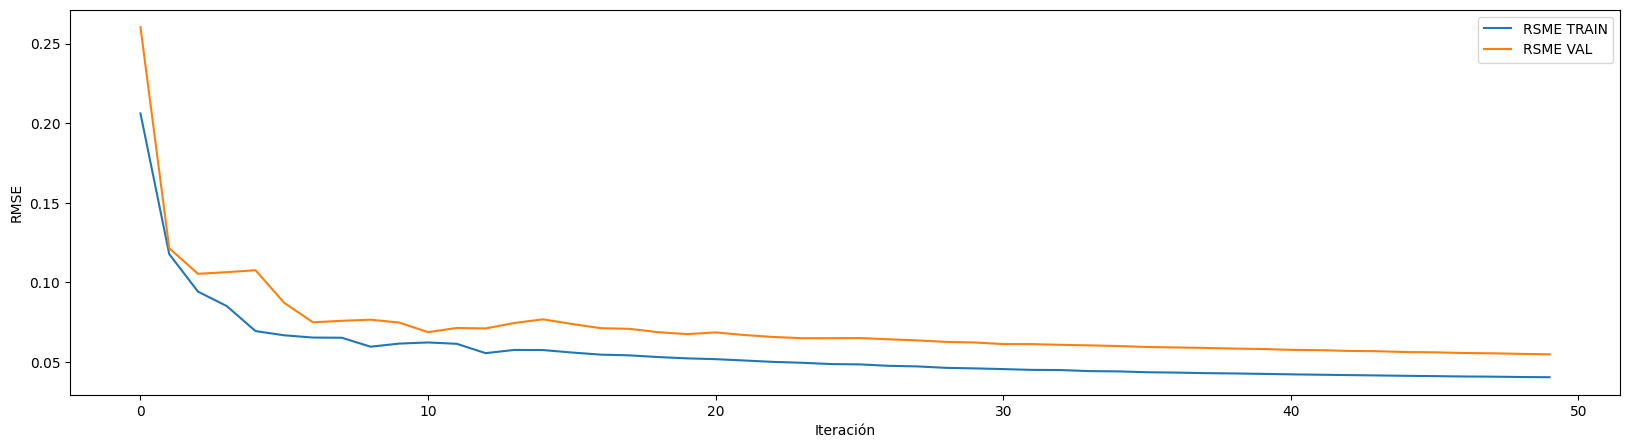

In [43]:
plt.subplots(figsize = (20,5))

plt.plot(historia.history['loss'],label = 'RSME TRAIN')

plt.plot(historia.history['val_loss'],label = 'RSME VAL')

plt.xlabel('Iteración')

plt.ylabel('RMSE')

plt.legend()

plt.show()

## Desempeño del modelo

In [44]:
# Cálculo de RSME para train, val y test

rmse_tr = modelo_2.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo_2.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo_2.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.034
  RMSE val:	 0.052
  RMSE test:	 0.066


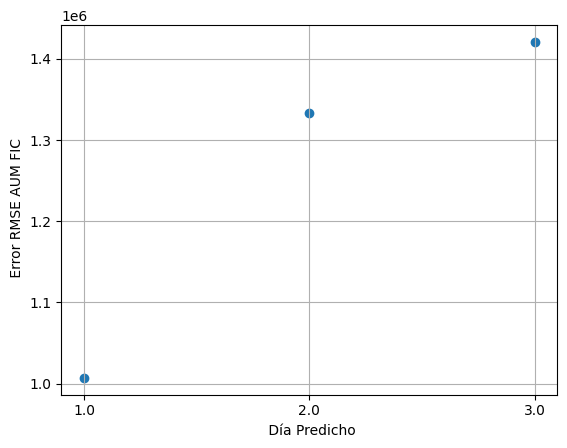

In [45]:
# Generar las predicciones sobre el set de prueba

y_ts_pred_s = modelo_2.predict(x_ts_s,verbose=0)

# Realizar la transformació n inversa de las predicciones para llevar los valores a la escala original

y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# Calcular  RMSE para cada instante de tiempo predicho

diff_cuad = np.square(y_ts.squeeze()-y_ts_pred)

proms = np.mean(diff_cuad, axis=0)

rmse = np.sqrt(proms)

# Graficar rmse para cada timestep

t = np.linspace(1,3,3)

fig, ax = plt.subplots()

ax.scatter(t,rmse)

ax.set_xlabel (' Día Predicho')

ax.set_ylabel(' Error RMSE AUM FIC')

plt.xticks(ticks=t, labels=t)

plt.grid()

## Predicciones

In [46]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = modelo_2.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [47]:
y_ts_pred = predecir(x_ts_s, modelo_2, scaler)

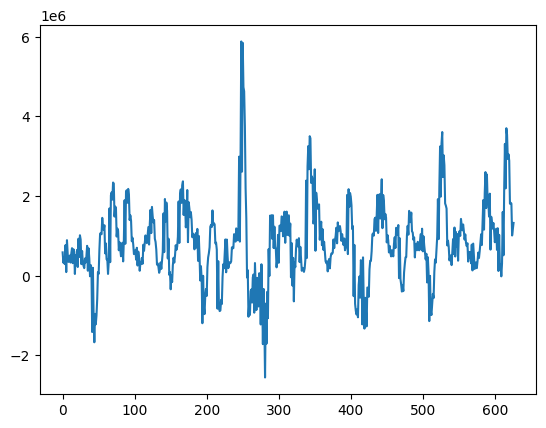

In [48]:
# Analizar el comportamiento de las predicciones a través de los errores

N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores)

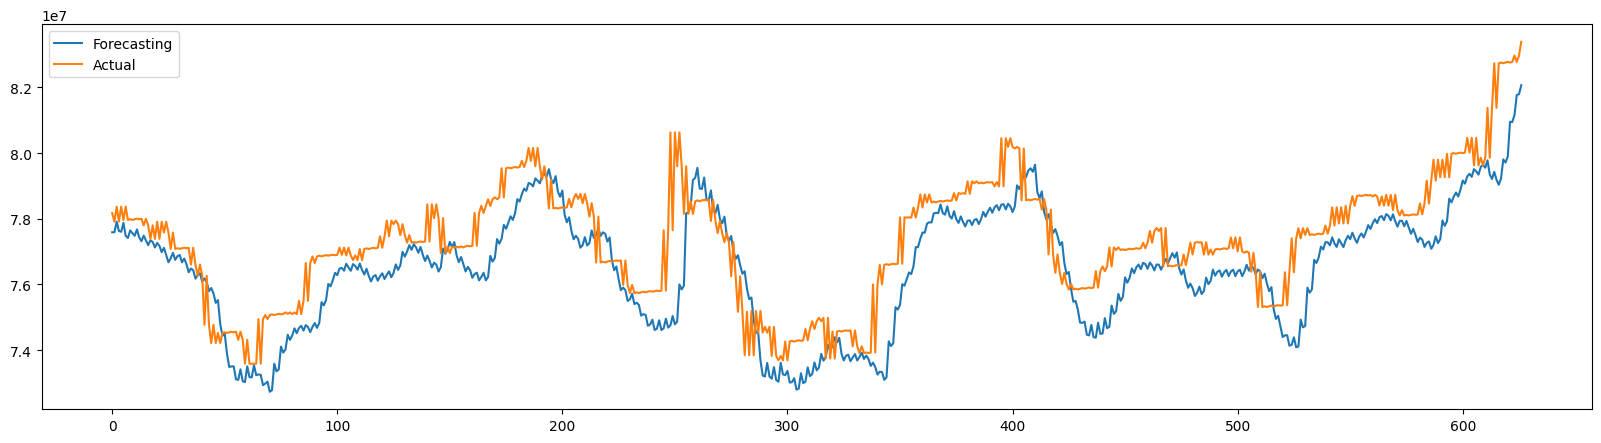

In [49]:
plt.subplots(figsize = (20,5))

plt.plot(y_ts_pred,label = 'Forecasting')

# plt.plot(ts,label = 'RSME TRAIN')

plt.plot(y_ts.flatten(),label = 'Actual')

plt.legend()

In [50]:
metricas_LSTM_3 = calculate_metrics(y_ts.flatten(),y_ts_pred)

# Modelo Multivariado - Unistep

## Preprocesamiento

Eliminar columna de tiempo

In [16]:
df_nuevo = df.reset_index()

df_nuevo = df_nuevo.drop(columns=['Fecha'])

df_nuevo = df_nuevo[['Efectivo','CDT 1/','Otros depósitos a la vista','Valor hoy','Tasa 30 días',
       'Tasa A 45 días', 'Cuentas de ahorro',
       'VALOR','AUM FIC']]

df_nuevo

,Efectivo,CDT 1/,Otros depósitos a la vista,Valor hoy,Tasa 30 días,Tasa A 45 días,Cuentas de ahorro,VALOR,AUM FIC
0,58512.003886,160226.125352,5328.184972,286.55,0.011996,0.045270,170017.348229,2940.94,4.277819e+07
1,58512.003886,160226.125352,5328.184972,286.55,0.011996,0.045270,170017.348229,2940.94,4.346588e+07
2,58512.003886,160226.125352,5328.184972,286.55,0.010830,0.000100,170017.348229,2940.94,4.427526e+07
3,58512.003886,160226.125352,5328.184972,286.55,0.012400,0.046500,170017.348229,2908.68,4.457223e+07
4,58512.003886,160226.125352,5328.184972,286.55,0.013152,0.046500,170017.348229,2885.76,4.464074e+07
...,...,...,...,...,...,...,...,...,...
2406,113349.537115,308954.440917,11117.476384,343.99,0.099563,0.097977,298898.800990,4022.05,8.276074e+07
2407,113349.537115,308954.440917,11117.476384,343.99,0.099563,0.097977,298898.800990,4022.05,8.277857e+07
2408,113349.537115,308954.440917,11117.476384,343.99,0.099563,0.097977,298898.800990,4022.05,8.297109e+07
2409,113349.537115,308954.440917,11117.476384,343.99,0.099563,0.097977,298898.800990,4022.05,8.339252e+07


In [17]:
tr2,vl2,ts2 = train_val_test_split(df_nuevo)

print(f'Tamaño set de entrenamiento: {tr2.shape}')

print(f'Tamaño set de validación: {vl2.shape}')

print(f'Tamaño set de prueba: {ts2.shape}')

Tamaño set de entrenamiento: (1928, 9)
Tamaño set de validación: (241, 9)
Tamaño set de prueba: (242, 9)


In [18]:
INPUT_LENGTH_3 = 30

OUPUT_LENGHT_3 = 1

x_tr, y_tr = crear_dataset_supervisado(tr2.values, INPUT_LENGTH_3, OUPUT_LENGHT_3)
x_vl, y_vl = crear_dataset_supervisado(vl2.values, INPUT_LENGTH_3, OUPUT_LENGHT_3)
x_ts, y_ts = crear_dataset_supervisado(ts2.values, INPUT_LENGTH_3, OUPUT_LENGHT_3)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (1897, 30, 9), y_tr: (1897, 1, 1)
Set de validación - x_vl: (210, 30, 9), y_vl: (210, 1, 1)
Set de prueba - x_ts: (211, 30, 9), y_ts: (211, 1, 1)


## Escalamiento

In [19]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in_2 = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}


In [20]:
# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset2(data_in_2, col_ref = 'AUM FIC' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

IndexError: index 9 is out of bounds for axis 2 with size 9

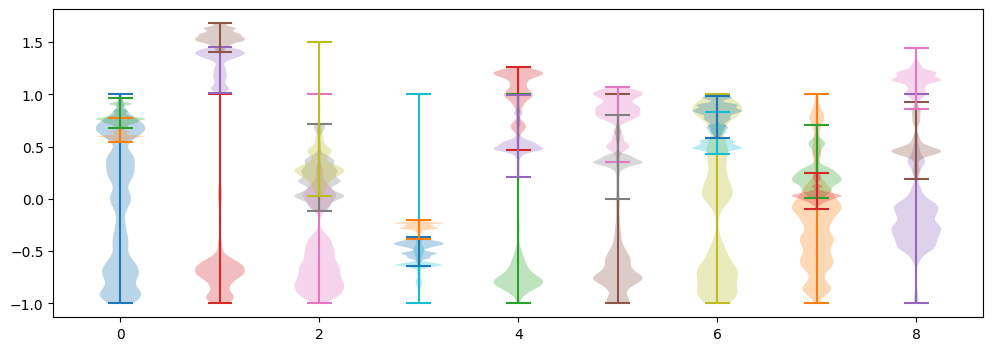

In [21]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(12):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(12)))
ax.set_xticklabels(df_nuevo.keys(), rotation=90)
ax.autoscale();

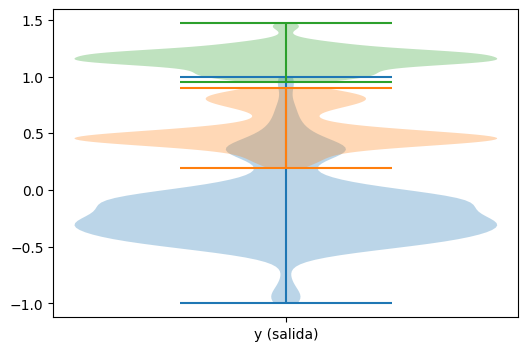

In [22]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

## Crear y entrenar el modelo

In [23]:
tf.random.set_seed(123)

tf.config.experimental.enable_op_determinism()

N_UNITS = 256

INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

modelo3 = Sequential()
modelo3.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo3.add(Dense(OUPUT_LENGHT_3, activation='linear'))

# Compilación

optimizador = RMSprop(learning_rate=0.005)

modelo3.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Hiperparámetros

EPOCHS = 50
BATCH_SIZE = 256

# Entrenar el modelo

historia = modelo3.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/50
8/8 - 1s - 173ms/step - loss: 1.0165 - val_loss: 0.1238
Epoch 2/50
8/8 - 0s - 62ms/step - loss: 0.1975 - val_loss: 0.4162
Epoch 3/50
8/8 - 0s - 62ms/step - loss: 0.1654 - val_loss: 0.2821
Epoch 4/50
8/8 - 1s - 75ms/step - loss: 0.1156 - val_loss: 0.2004
Epoch 5/50
8/8 - 1s - 123ms/step - loss: 0.1138 - val_loss: 0.2857
Epoch 6/50
8/8 - 1s - 136ms/step - loss: 0.1035 - val_loss: 0.2233
Epoch 7/50
8/8 - 1s - 140ms/step - loss: 0.0998 - val_loss: 0.1904
Epoch 8/50
8/8 - 1s - 129ms/step - loss: 0.0804 - val_loss: 0.2040
Epoch 9/50
8/8 - 1s - 111ms/step - loss: 0.1018 - val_loss: 0.1896
Epoch 10/50
8/8 - 1s - 148ms/step - loss: 0.0802 - val_loss: 0.1674
Epoch 11/50
8/8 - 1s - 131ms/step - loss: 0.1013 - val_loss: 0.1431
Epoch 12/50
8/8 - 1s - 101ms/step - loss: 0.0768 - val_loss: 0.1035
Epoch 13/50
8/8 - 1s - 151ms/step - loss: 0.0789 - val_loss: 0.1404
Epoch 14/50
8/8 - 1s - 127ms/step - loss: 0.0740 - val_loss: 0.1385
Epoch 15/50
8/8 - 1s - 129ms/step - loss: 0.0697 - val_loss:

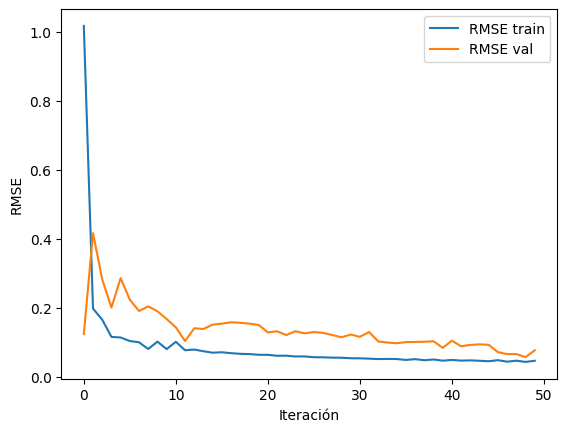

In [24]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

## Desempeño del modelo

In [25]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo3.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo3.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo3.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.038
  RMSE val:	 0.076
  RMSE test:	 0.073


## Predicciones

In [26]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo3, scaler)

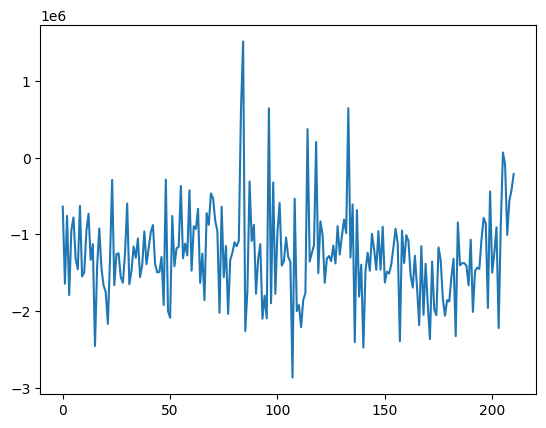

In [27]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

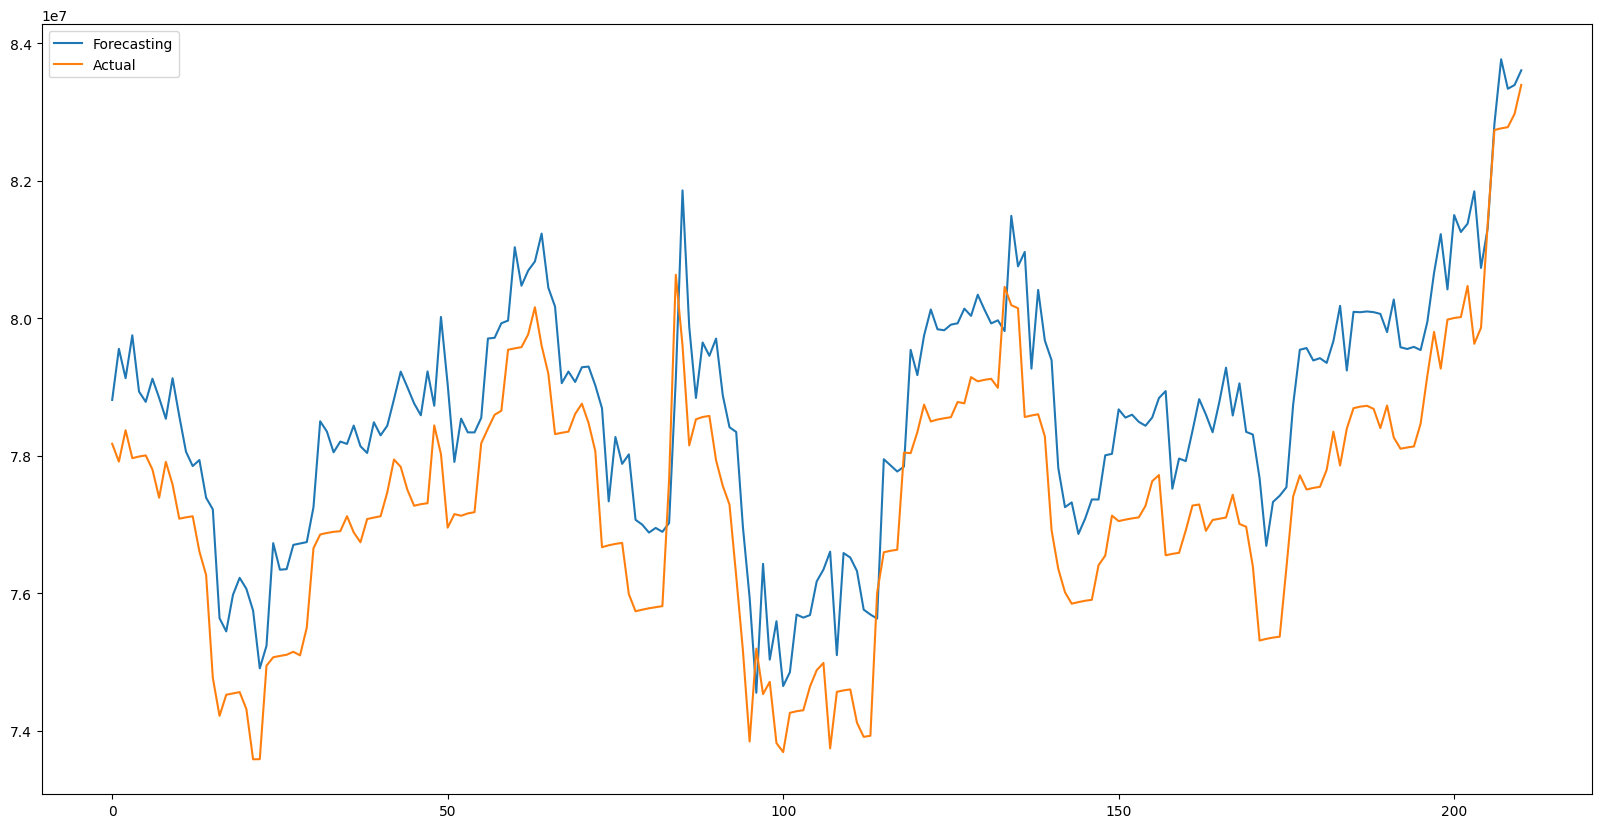

In [28]:
plt.subplots(figsize = (20,10))

plt.plot(y_ts_pred,label = 'Forecasting')

# plt.plot(ts,label = 'RSME TRAIN')

plt.plot(y_ts.flatten(),label = 'Actual')

plt.legend()

In [ ]:
metricas_LSTM_4 = calculate_metrics(y_ts.flatten(),y_ts_pred)


In [30]:
metricas_LSTM_4

(1938704361333.8047,
 1392373.6428609258,
 1294120.9886576217,
 1.6797072203976553)

## Afinar hiperparámetros

In [31]:
# Semilla generador aleatorio

tf.config.experimental.enable_op_determinism()

tf.random.set_seed(123)

INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

def build_model(hp):
    
    model = Sequential()

    # Capas LSTM

    model.add(LSTM(hp.Choice('units',values = [128,256,512]), return_sequences=True, input_shape=INPUT_SHAPE))

    
    # model.add(Dropout(hp.Choice('dropout',values = [0.1, 0.2, 0.3])))


    # Capas de salida

    model.add(Dense(OUPUT_LENGHT_3, activation='linear'))
    
    # Compilación del modelo

    optimizer = RMSprop(hp.Choice('learning_rate',values = [0.000005,0.00005, 0.0005, 0.005,0.05]))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')

      
    return model

In [32]:
tuner = RandomSearch(
    build_model,
    objective='val_loss', # Mérica de desempeño a usar en la afinación
    max_trials= 20,  # Número de combinaciones diferentes a probar
    # executions_per_trial=3,  # Número de veces que entrenarás cada modelo
    directory='my_dir',
    project_name='LSTM_tuning',
    overwrite = True
)

In [33]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
learning_rate (Choice)
{'default': 5e-06, 'conditions': [], 'values': [5e-06, 5e-05, 0.0005, 0.005, 0.05], 'ordered': True}


In [34]:
tuner.search(x_tr_s, y_tr_s, 
             epochs=50,
             batch_size=256,
             validation_data=(x_vl_s, y_vl_s),verbose=2)
   

Trial 13 Complete [00h 01m 10s]
val_loss: 0.06340920925140381

Best val_loss So Far: 0.029355522245168686
Total elapsed time: 00h 13m 16s


In [35]:
# Imprimir resumen de la afinación

tuner.results_summary()

Results summary
Results in my_dir\LSTM_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
units: 128
learning_rate: 0.05
Score: 0.029355522245168686

Trial 08 summary
Hyperparameters:
units: 256
learning_rate: 0.005
Score: 0.03047911636531353

Trial 09 summary
Hyperparameters:
units: 128
learning_rate: 0.005
Score: 0.03243565559387207

Trial 11 summary
Hyperparameters:
units: 256
learning_rate: 0.05
Score: 0.0362076498568058

Trial 07 summary
Hyperparameters:
units: 512
learning_rate: 0.005
Score: 0.04129905253648758

Trial 03 summary
Hyperparameters:
units: 512
learning_rate: 0.0005
Score: 0.04352875053882599

Trial 04 summary
Hyperparameters:
units: 256
learning_rate: 0.0005
Score: 0.04354679584503174

Trial 00 summary
Hyperparameters:
units: 128
learning_rate: 5e-05
Score: 0.05373045429587364

Trial 06 summary
Hyperparameters:
units: 256
learning_rate: 5e-05
Score: 0.055589038878679276

Trial 12 summary
Hyperparameters:
units

In [36]:
# Extraer el mejor modelo
mejor_modelo2 = tuner.get_best_models(num_models=1)[0]
# mejor_modelo.summary()

In [37]:
# Cálculo de RSME para train, val y test

rmse_tr = mejor_modelo2.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = mejor_modelo2.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = mejor_modelo2.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.045
  RMSE val:	 0.029
  RMSE test:	 0.165


In [38]:
predecir2 = mejor_modelo2.predict(x_ts_s,verbose=0)[:,0,:]

predecir2 = scaler.inverse_transform(predecir2)


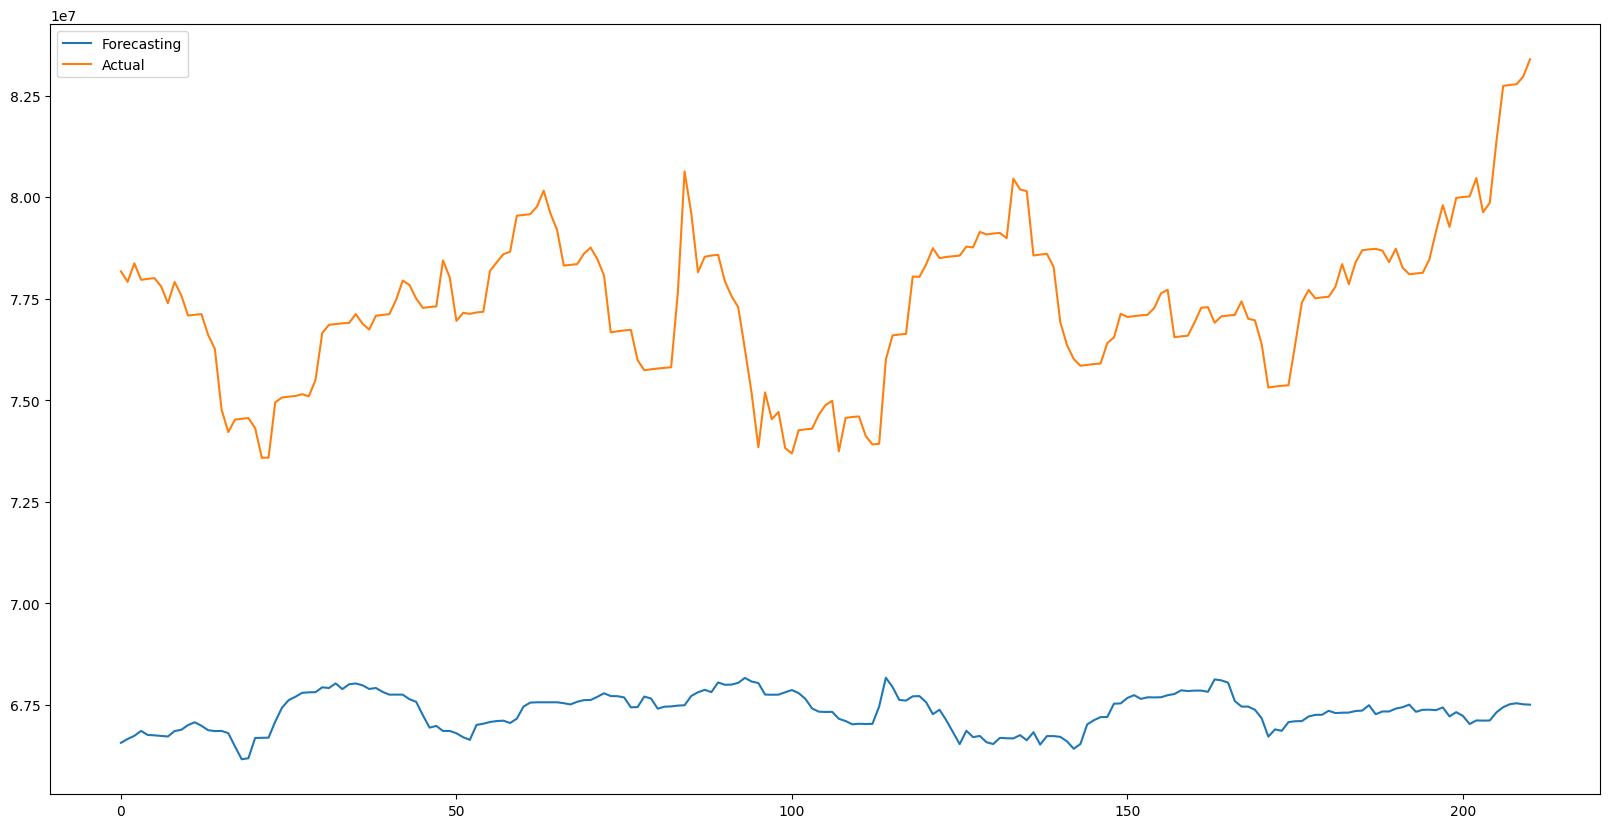

In [39]:
plt.subplots(figsize = (20,10))

plt.plot(predecir2,label = 'Forecasting')

# plt.plot(ts,label = 'RSME TRAIN')

plt.plot(y_ts.flatten(),label = 'Actual')

plt.legend()

In [40]:
metricas_LSTM_5 = calculate_metrics(y_ts.flatten(),predecir2)

In [78]:
# Comparar resultados
resultados = pd.DataFrame({
    'Model': ['LSTM1 Univariado- Unistep','LSTM2 Univariado - Unistep Optimized','LSTM3 Univariado - Multistep','LSTM4 MUltivariado- Unistep','LSTM5 MUltivariado- Unistep Optimizado'],
    'MSE': [metricas_LSTM_1[0],metricas_LSTM_2[0],metricas_LSTM_3[0],metricas_LSTM_4[0],metricas_LSTM_5[0]],
    'RMSE': [metricas_LSTM_1[1],metricas_LSTM_2[1],metricas_LSTM_3[1],metricas_LSTM_4[1],metricas_LSTM_5[1]],
    'MAE': [metricas_LSTM_1[2],metricas_LSTM_2[2],metricas_LSTM_3[2],metricas_LSTM_4[2],metricas_LSTM_5[2]],
    'MAPE': [metricas_LSTM_1[3],metricas_LSTM_2[3],metricas_LSTM_3[3],metricas_LSTM_4[3],metricas_LSTM_5[3]]
})

resultados

,Model,MSE,RMSE,MAE,MAPE
0,LSTM1 Univariado- Unistep,6.347539e+11,7.967144e+05,6.298653e+05,0.814211
1,LSTM2 Univariado - Unistep Optimized,1.038980e+14,1.019304e+07,9.976939e+06,12.847606
2,LSTM3 Univariado - Multistep,1.603045e+12,1.266114e+06,9.990759e+05,1.287202
3,LSTM4 MUltivariado- Unistep,9.377846e+12,3.062327e+06,2.979622e+06,3.855252
4,LSTM5 MUltivariado- Unistep Optimizado,3.657294e+13,6.047557e+06,5.654581e+06,7.256589


# Multivariado Unistep 2

In [41]:
df_nuevo_principales_variables = df.reset_index()

df_nuevo_principales_variables = df_nuevo_principales_variables.drop(columns=['Fecha'])

df_nuevo_principales_variables = df_nuevo_principales_variables[['CDT 1/','Efectivo','AUM FIC']]

df_nuevo_principales_variables

,CDT 1/,Efectivo,AUM FIC
0,160226.125352,58512.003886,4.277819e+07
1,160226.125352,58512.003886,4.346588e+07
2,160226.125352,58512.003886,4.427526e+07
3,160226.125352,58512.003886,4.457223e+07
4,160226.125352,58512.003886,4.464074e+07
...,...,...,...
2406,308954.440917,113349.537115,8.276074e+07
2407,308954.440917,113349.537115,8.277857e+07
2408,308954.440917,113349.537115,8.297109e+07
2409,308954.440917,113349.537115,8.339252e+07


In [42]:
tr3,vl3,ts3 = train_val_test_split(df_nuevo_principales_variables)

print(f'Tamaño set de entrenamiento: {tr3.shape}')

print(f'Tamaño set de validación: {vl3.shape}')

print(f'Tamaño set de prueba: {ts3.shape}')

Tamaño set de entrenamiento: (1928, 3)
Tamaño set de validación: (241, 3)
Tamaño set de prueba: (242, 3)


In [43]:
INPUT_LENGTH_4 = 30

OUPUT_LENGHT_4 = 1

x_tr, y_tr = crear_dataset_supervisado(tr3.values, INPUT_LENGTH_4, OUPUT_LENGHT_4)
x_vl, y_vl = crear_dataset_supervisado(vl3.values, INPUT_LENGTH_4, OUPUT_LENGHT_4)
x_ts, y_ts = crear_dataset_supervisado(ts3.values, INPUT_LENGTH_4, OUPUT_LENGHT_4)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (1897, 30, 3), y_tr: (1897, 1, 1)
Set de validación - x_vl: (210, 30, 3), y_vl: (210, 1, 1)
Set de prueba - x_ts: (211, 30, 3), y_ts: (211, 1, 1)


In [44]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in_3 = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}


In [45]:
# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset2(data_in_3, col_ref = 'AUM FIC' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [46]:
tf.random.set_seed(123)

tf.config.experimental.enable_op_determinism()

N_UNITS = 256

INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])

modelo4 = Sequential()
modelo4.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo4.add(Dense(OUPUT_LENGHT_4, activation='linear'))

# Compilación

optimizador = RMSprop(learning_rate=0.005)

modelo4.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Hiperparámetros

EPOCHS = 200
BATCH_SIZE = 256

# Entrenar el modelo

historia = modelo4.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/200
8/8 - 1s - 160ms/step - loss: 0.5497 - val_loss: 0.1409
Epoch 2/200
8/8 - 1s - 77ms/step - loss: 0.1550 - val_loss: 0.1384
Epoch 3/200
8/8 - 1s - 64ms/step - loss: 0.1103 - val_loss: 0.1798
Epoch 4/200
8/8 - 1s - 67ms/step - loss: 0.1042 - val_loss: 0.1271
Epoch 5/200
8/8 - 1s - 114ms/step - loss: 0.0760 - val_loss: 0.2032
Epoch 6/200
8/8 - 1s - 115ms/step - loss: 0.1005 - val_loss: 0.1830
Epoch 7/200
8/8 - 1s - 137ms/step - loss: 0.1069 - val_loss: 0.1255
Epoch 8/200
8/8 - 1s - 120ms/step - loss: 0.1034 - val_loss: 0.4122
Epoch 9/200
8/8 - 1s - 107ms/step - loss: 0.0836 - val_loss: 0.1737
Epoch 10/200
8/8 - 1s - 124ms/step - loss: 0.0700 - val_loss: 0.1022
Epoch 11/200
8/8 - 1s - 110ms/step - loss: 0.0652 - val_loss: 0.1386
Epoch 12/200
8/8 - 1s - 123ms/step - loss: 0.0681 - val_loss: 0.0745
Epoch 13/200
8/8 - 1s - 111ms/step - loss: 0.0577 - val_loss: 0.1004
Epoch 14/200
8/8 - 1s - 131ms/step - loss: 0.0628 - val_loss: 0.1174
Epoch 15/200
8/8 - 1s - 114ms/step - loss: 0.0

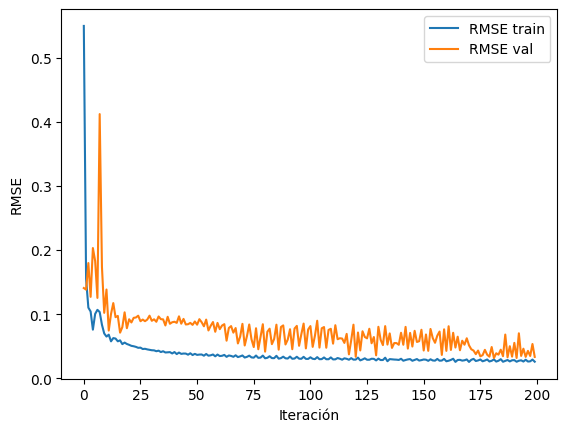

In [47]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

In [48]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo4.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo4.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo4.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.026
  RMSE val:	 0.032
  RMSE test:	 0.077


In [49]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo4, scaler)

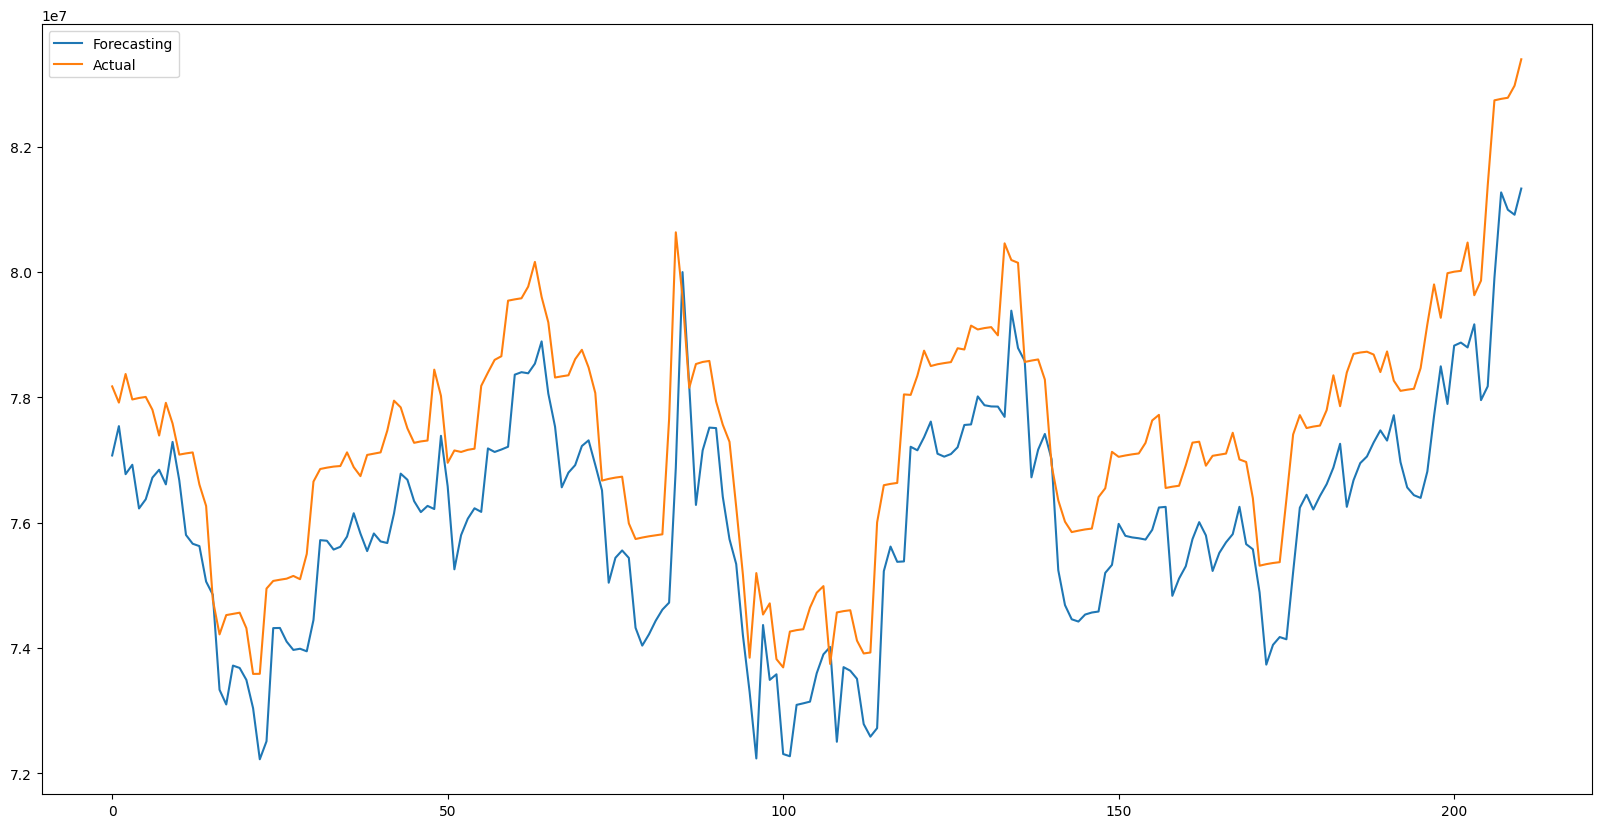

In [50]:
plt.subplots(figsize = (20,10))

plt.plot(y_ts_pred,label = 'Forecasting')

# plt.plot(ts,label = 'RSME TRAIN')

plt.plot(y_ts.flatten(),label = 'Actual')

plt.legend()

In [51]:
metricas_LSTM_6 = calculate_metrics(y_ts.flatten(),y_ts_pred)

In [159]:
# Comparar resultados
resultados = pd.DataFrame({
    'Model': ['LSTM1 Univariado- Unistep','LSTM2 Univariado - Unistep Optimized','LSTM3 Univariado - Multistep','LSTM4 MUltivariado (11 variables)- Unistep','LSTM5 MUltivariado (11 variables)- Unistep Optimizado','LSTM6 MUltivariado (2 variables)- Unistep'],
    'MSE': [metricas_LSTM_1[0],metricas_LSTM_2[0],metricas_LSTM_3[0],metricas_LSTM_4[0],metricas_LSTM_5[0],metricas_LSTM_6[0]],
    'RMSE': [metricas_LSTM_1[1],metricas_LSTM_2[1],metricas_LSTM_3[1],metricas_LSTM_4[1],metricas_LSTM_5[1],metricas_LSTM_6[1]],
    'MAE': [metricas_LSTM_1[2],metricas_LSTM_2[2],metricas_LSTM_3[2],metricas_LSTM_4[2],metricas_LSTM_5[2],metricas_LSTM_6[2]],
    'MAPE': [metricas_LSTM_1[3],metricas_LSTM_2[3],metricas_LSTM_3[3],metricas_LSTM_4[3],metricas_LSTM_5[3],metricas_LSTM_6[3]]
})

resultados

,Model,MSE,RMSE,MAE,MAPE
0,LSTM1 Univariado- Unistep,6.347539e+11,7.967144e+05,6.298653e+05,0.814211
1,LSTM2 Univariado - Unistep Optimized,1.038980e+14,1.019304e+07,9.976939e+06,12.847606
2,LSTM3 Univariado - Multistep,1.603045e+12,1.266114e+06,9.990759e+05,1.287202
3,LSTM4 MUltivariado (11 variables)- Unistep,9.377846e+12,3.062327e+06,2.979622e+06,3.855252
4,LSTM5 MUltivariado (11 variables)- Unistep Opt...,3.657294e+13,6.047557e+06,5.654581e+06,7.256589
5,LSTM6 MUltivariado (2 variables)- Unistep,5.913700e+11,7.690059e+05,5.996138e+05,0.774149


In [52]:
metricas_LSTM_4

(1938704361333.8047,
 1392373.6428609258,
 1294120.9886576217,
 1.6797072203976553)

In [53]:
metricas_LSTM_5

(104095841259644.06,
 10202736.949448617,
 10018534.679530567,
 12.901410599723862)

In [54]:
metricas_LSTM_6

(2113307433962.3394, 1453721.9245654717, 1326450.5159657828, 1.710207255130555)